## Import Liberaries

In [1]:
import json 
import re 
import numpy as np 
import pandas as pd
import numpy as np
import string
import nltk
import seaborn as sns

from scipy.sparse import csr_matrix, hstack
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.initializers import RandomNormal
from keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential 
from nltk.stem.snowball import SnowballStemmer 
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

##  Read data

In [2]:
data=pd.read_csv('train.csv')

In [3]:
data.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
data = data.drop(['id'], axis=1)

Remove id ,we won't need it anymore

## EDA & Feature Engineering 

### Handling missing value in keyword

In [6]:
data['keyword'].nunique()

221

In [7]:
data['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [8]:
data['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
harm                     41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
data['keyword'].isnull().sum()

61

In [10]:
print("missing values :", round((data['keyword'].isnull().sum()/data.shape[0])*100),'%')

missing values : 1 %


In [11]:
data['keyword'] = data['keyword'].fillna('empty')

In [12]:
data[data['target'] == 1]['keyword'].value_counts()

empty          42
wreckage       39
outbreak       39
derailment     39
oil%20spill    37
               ..
ruin            1
body%20bag      1
epicentre       1
blazing         1
body%20bags     1
Name: keyword, Length: 221, dtype: int64

In [13]:
data[data['target'] == 0]['keyword'].value_counts()

body%20bags          40
armageddon           37
harm                 37
deluge               36
wrecked              36
                     ..
typhoon               1
outbreak              1
suicide%20bombing     1
suicide%20bomber      1
oil%20spill           1
Name: keyword, Length: 219, dtype: int64

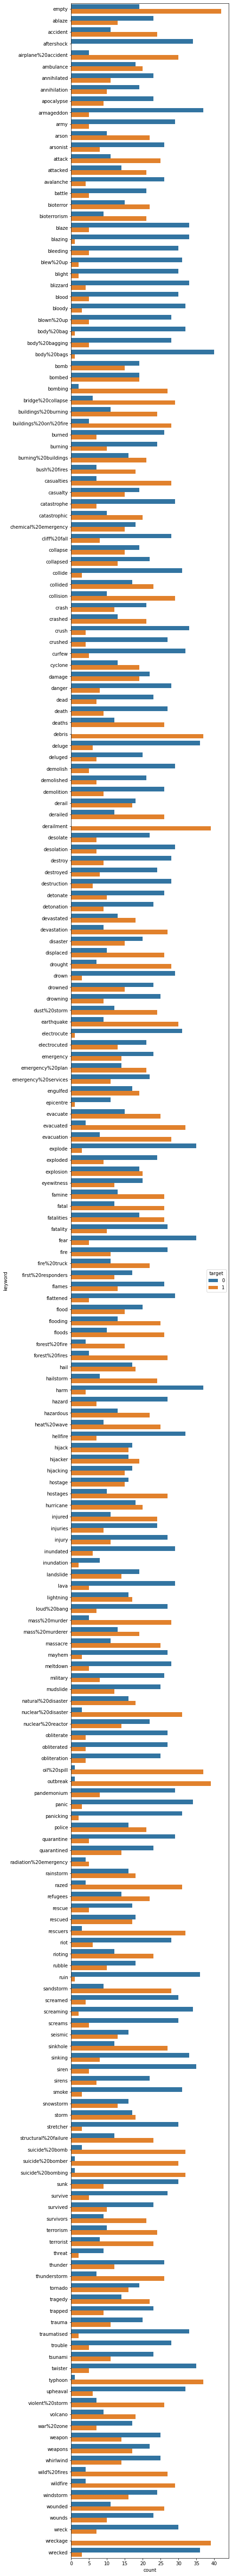

In [14]:
plt.figure(figsize=(6,100))
sns.countplot(data=data, y='keyword', hue='target');

### Handling missing value in location

In [15]:
data['location'].nunique()

3341

In [16]:
data['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [17]:
data['location'].value_counts()

USA                     104
New York                 71
United States            50
London                   45
Canada                   29
                       ... 
with Doflamingo           1
Durham N.C                1
DÌ_sseldorf, Germany      1
Tucson, Arizona           1
Kenosha, WI 53143         1
Name: location, Length: 3341, dtype: int64

In [18]:
data['location'].isnull().sum()

2533

In [19]:
print("missing values :", round((data['location'].isnull().sum()/data.shape[0])*100),'%')

missing values : 33 %


In [20]:
data[data['target'] == 1]['location'].value_counts()

USA                  67
United States        27
Nigeria              22
India                20
Mumbai               19
                     ..
Homs- Syria           1
London, Sydney        1
CORNFIELDS            1
Lexington             1
Edmonton, Alberta     1
Name: location, Length: 1513, dtype: int64

In [21]:
data[data['target'] == 0]['location'].value_counts()

New York                   55
USA                        37
London                     29
United States              23
Los Angeles, CA            18
                           ..
PSN: Pipbois                1
The Meadow                  1
The Empire/First Order      1
chillin at ceder rapids     1
Kenosha, WI 53143           1
Name: location, Length: 2142, dtype: int64

In [22]:
top_location = data['location'].value_counts(normalize=True).head(50).index

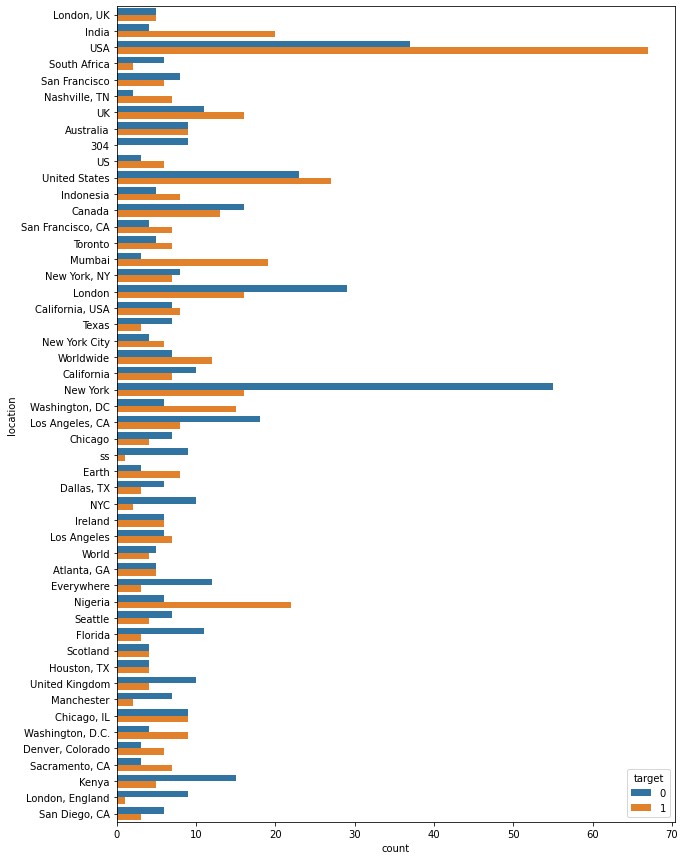

In [23]:
plt.figure(figsize=(10,15))
sns.countplot(data=data[data['location'].isin(top_location)], y='location', hue='target');

In [24]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

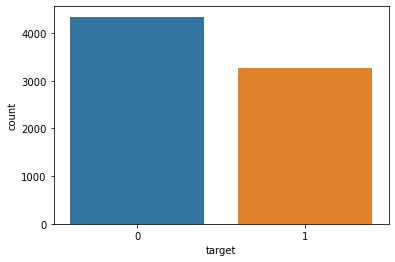

In [25]:
sns.countplot(data=data,x='target')

In [26]:
data = data.drop(['location'], axis=1)

Remove the location, we decided that due to the large number of missing values, it will not help in training the model

In [27]:
# show some of real and fake data to notice the difference between them

real_tweets = data[data['target']==1]['text']
fake_tweets = data[data['target']==0]['text']

print('real_tweets:\n')
for i in range(5):
    print(real_tweets[i],'\n')
    
'''print('fake_tweets:\n')
for i in range(5,10):
    if fake_tweets[i] is not None:
        print(fake_tweets[i],'\n')'''



real_tweets:

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

Forest fire near La Ronge Sask. Canada 

All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 

13,000 people receive #wildfires evacuation orders in California  

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  



"print('fake_tweets:\n')\nfor i in range(5,10):\n    if fake_tweets[i] is not None:\n        print(fake_tweets[i],'\n')"

 the difference between a real tweet and a fake tweet.

real tweets have a longer text length than fake tweets, seem to have more numbers in the text, contain more punctuation in the text, contain more links and more hastags.

we will generate new features and see how they affect the target feature, Let's start by creating "len_text"

In [28]:
data['len_text'] = data['text'].apply(len)

In [29]:
data.groupby(['target'])['len_text'].describe().T

target,0,1
count,4342.000000,3271.000000
mean,95.706817,108.113421
std,35.885924,29.309854
min,7.000000,14.000000
25%,68.000000,88.000000
50%,101.000000,115.000000
75%,130.000000,136.000000
max,157.000000,151.000000


<AxesSubplot:xlabel='len_text', ylabel='target'>

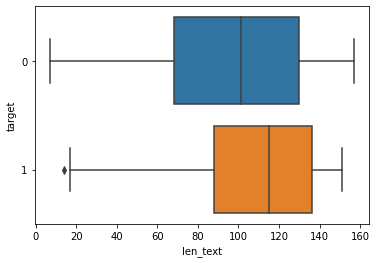

In [30]:
sns.boxplot(data=data, x='len_text', y='target', orient='h')

#### standardize len_text

In [31]:
from sklearn.preprocessing import MinMaxScaler
scal = MinMaxScaler()
scal.fit(data['len_text'].values.reshape(-1,1))
data['len_text'] = scal.transform(data['len_text'].values.reshape(-1,1))

In [32]:
def check_digits(text):
    if [char for char in text if char in string.digits]:
        return 1
    else:
        return 0
    
def check_punctation(text):
    if [char for char in text if char in string.punctuation]:
        return 1
    else:
        return 0
    
def count_punctation(text):
    count = 0
    for char in text:
        if char in string.punctuation:    
            count +=1
    return count

def count_digits(text):
    count = 0
    for char in text:
        if char in string.digits:    
            count +=1
    return count

In [33]:
data['check_digits'] = data['text'].apply(lambda x: check_digits(x))
data['check_punctation'] = data['text'].apply(lambda x: check_punctation(x))
data['count_punctation'] = data['text'].apply(lambda x: count_punctation(x))
data['count_digits'] = data['text'].apply(lambda x: count_digits(x))

In [34]:
data.groupby(['target'])['count_punctation'].describe().T

target,0,1
count,4342.000000,3271.000000
mean,6.309074,7.543565
std,4.830297,4.195437
min,0.000000,0.000000
25%,3.000000,5.000000
50%,6.000000,7.000000
75%,9.000000,10.000000
max,61.000000,27.000000


<AxesSubplot:xlabel='count_punctation', ylabel='target'>

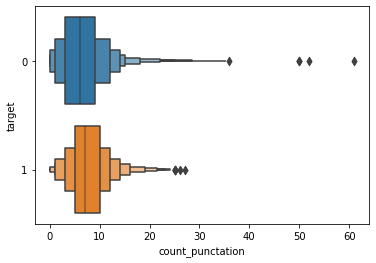

In [35]:
sns.boxenplot(data=data, x='count_punctation', y='target', orient='h')

In [36]:
data.groupby(['target'])['count_digits'].mean()

target
0    1.590511
1    2.637420
Name: count_digits, dtype: float64

<AxesSubplot:xlabel='count_digits', ylabel='target'>

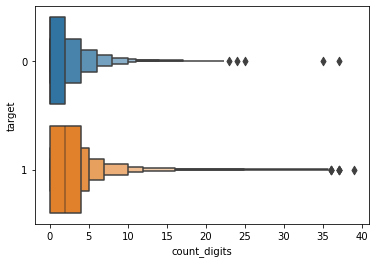

In [37]:
sns.boxenplot(data=data, x='count_digits', y='target', orient='h')

<AxesSubplot:xlabel='check_digits', ylabel='count'>

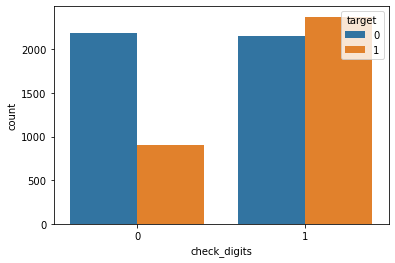

In [38]:
sns.countplot(data=data, x='check_digits', hue='target')

there are a corelation between check digits and the target.

<AxesSubplot:xlabel='check_punctation', ylabel='count'>

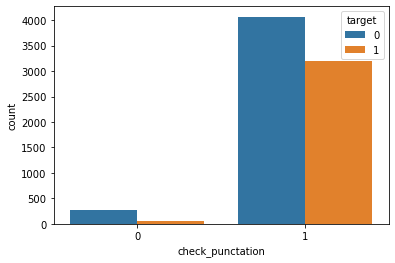

In [39]:
sns.countplot(data=data, x='check_punctation', hue='target')

there are no corelation between check puctation and the target, so lets remove this feature.

In [40]:
data = data.drop(['check_punctation'], axis=1)

In [41]:
data['check_http'] = data['text'].str.contains('http')
data['check_hash'] = data['text'].str.contains('#')

<AxesSubplot:xlabel='check_http', ylabel='count'>

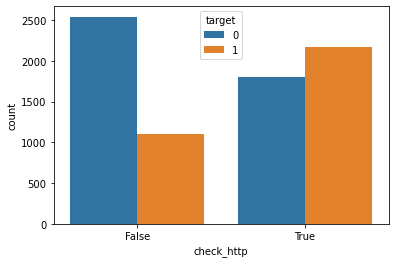

In [42]:
sns.countplot(data=data, x='check_http', hue='target')

there are a corelation between check http and the target.

<AxesSubplot:xlabel='check_hash', ylabel='count'>

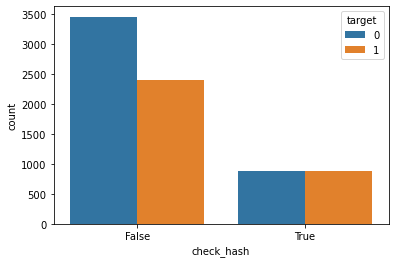

In [43]:
sns.countplot(data=data, x='check_hash', hue='target')

In [44]:
data['check_http'] = data['check_http'].apply(lambda x: 1 if x else 0)
data['check_hash'] = data['check_hash'].apply(lambda x: 1 if x else 0)

In [45]:
data.head()

,keyword,text,target,len_text,check_digits,count_punctation,count_digits,check_http,check_hash
0,empty,Our Deeds are the Reason of this #earthquake M...,1,0.413333,0,1,0,0,1
1,empty,Forest fire near La Ronge Sask. Canada,1,0.206667,0,1,0,0,0
2,empty,All residents asked to 'shelter in place' are ...,1,0.840000,0,3,0,0,0
3,empty,"13,000 people receive #wildfires evacuation or...",1,0.386667,1,2,5,0,1
4,empty,Just got sent this photo from Ruby #Alaska as ...,1,0.540000,0,2,0,0,1


<AxesSubplot:>

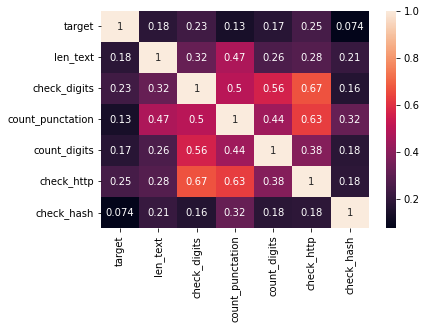

In [46]:
sns.heatmap(data.corr(), annot=True)

## Text Preprocessing (clean text)

remove all stop-words

Convert all text to lowercase

Remove all other characters that are not alpha, numbers and space

Remove extra spaces between words

In [47]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
nltk.download('punkt')
stemmer  = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olaab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olaab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
from nltk.stem import WordNetLemmatizer 
le=WordNetLemmatizer()

#### functions 1 to clean data

In [49]:
def process_tweets(tweets):
    
    clean_tweets=[]
    for tweet in tweets :
        tweet=re.sub(r'(@|#)[a-zA-Z0-9_]*','',tweet) # remove mention & hashatge
        tweet=re.sub(r'https?:\/\/\S+','',tweet)# remove hyperlink http:\\ Or  https:\\wwcwvevv ahmed
        tweet=re.sub("\W"," ",tweet)# remove punc
        tweet=re.sub('^\s+',"",tweet) # remove space 
        tweet=re.sub('\s+$',"",tweet) # remove space

        # remove stop words && lemmatizer 
        
        clean_tweet=[le.lemmatize(word.lower())  for word in tweet.split() if word.lower() not in stop_words ]
        
        clean_tweets.append(clean_tweet)
        
    return clean_tweets

#### functions 2 to clean data

In [50]:
def clean_text(tweets):
    
    clean_tweets=[]
    for text in tweets :
        text = text.lower()
        text = ' '.join([char for char in text.split() if char not in stop_words])

        text = ' '.join(['' if 'http' in char else char for char in text.split()])

        text = ''.join([char+' ' if char in string.punctuation else char for char in text ])

        text = ''.join([char for char in text if char in string.ascii_lowercase or char in ' ' or  char in string.digits])

        text = ' '.join(text.split())
        clean_tweets.append(text)
    
    return clean_tweets

In [51]:
data['clean_text']=clean_text(data['text'])

In [52]:
#data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join(x))

###### I use sample() to shuffle the data

In [53]:
data = data.sample(frac=1).reset_index(drop=True)

 we calculate the frequency of occurrences in clean_text and keyword. This is necessary to give lower weights to frequently used words.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
tokenizer=Tokenizer()

def process_padd_sequence(data):
    tokenizer.fit_on_texts(data)
    sequences=tokenizer.texts_to_sequences(data)
    paded_sequences=pad_sequences(sequences,maxlen=26)
    return paded_sequences

In [56]:
data['clean_text_sequence']=data['clean_text'].apply(lambda x: process_padd_sequence(x))
data['keyword_sequence']=data['keyword'].apply(lambda x: process_padd_sequence(x))

In [57]:
data.head()

,keyword,text,target,len_text,check_digits,count_punctation,count_digits,check_http,check_hash,clean_text,clean_text_sequence,keyword_sequence
0,trapped,I trapped this cat in my room and it's going i...,0,0.700000,1,9,1,1,0,trapped cat room going insane leaving pretty,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,arsonist,#Vegetarian #Vegan Video shows arsonist torchi...,0,0.860000,1,12,1,1,1,vegetarian vegan video shows arsonist torching...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,eyewitness,Lone Survivor: The Eyewitness Account of Opera...,1,0.886667,1,12,1,1,0,lone survivor eyewitness account operation red...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,rubble,'Refuse to let my life be reduced to rubble. W...,0,0.613333,0,5,0,0,0,refuse let life reduced rubble shit keeps pili...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,buildings%20on%20fire,#TweetLikeItsSeptember11th2001 Those two build...,1,0.366667,1,1,6,0,1,tweetlikeitsseptember11th2001 two buildings fire,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [58]:
# data2 contains only numeric values
data2=data.copy()

In [59]:
data2.drop(['keyword','text','clean_text'],axis=1)

,target,len_text,check_digits,count_punctation,count_digits,check_http,check_hash,clean_text_sequence,keyword_sequence
0,0,0.700000,1,9,1,1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,0.860000,1,12,1,1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1,0.886667,1,12,1,1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0,0.613333,0,5,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1,0.366667,1,1,6,0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...
7608,1,0.746667,0,4,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7609,0,0.746667,0,4,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7610,0,0.360000,0,2,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7611,0,0.886667,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [60]:
X = data['clean_text']

y = data['target']
#X_test = data.copy()
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,np.array(y),test_size=0.16,random_state=42,shuffle=True)

#### Vectorizing with TFIDF

In [61]:
tfid = TfidfVectorizer()

X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

#### convert text to squences

In [62]:
tokenizer=Tokenizer()

tokenizer.fit_on_texts(X_train)
sequences=tokenizer.texts_to_sequences(X_train)
paded_sequences=pad_sequences(sequences,maxlen=26)

tokenizer.fit_on_texts(X_test)
sequences=tokenizer.texts_to_sequences(X_test)
paded_test=pad_sequences(sequences,maxlen=26)

### Machine learning models

#### Naive Bayes

In [63]:
nb = MultinomialNB()
nb.fit(X_train_tfid,y_train)

y_pred=nb.predict(X_test_tfid)
print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

print("training accuracy: ", nb.score(X_train_tfid,y_train)*100)
print("testing accuracy: ", nb.score(X_test_tfid,y_test)*100)

Accuracy :  80.55783429040197
training accuracy:  90.45980606818893
testing accuracy:  80.55783429040197


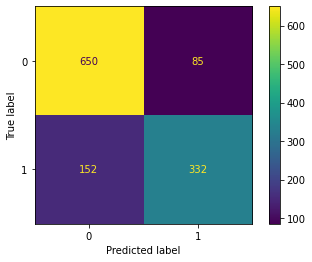

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=nb.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=nb.classes_)
disp.plot();

#### Logistic regression

In [65]:
lr = LogisticRegression()
lr.fit(X_train_tfid,y_train)

y_pred=lr.predict(X_test_tfid)
print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

print("training accuracy: ", lr.score(X_train_tfid,y_train)*100)
print("testing accuracy: ", lr.score(X_test_tfid,y_test)*100)

Accuracy :  81.70631665299426
training accuracy:  89.13043478260869
testing accuracy:  81.70631665299426


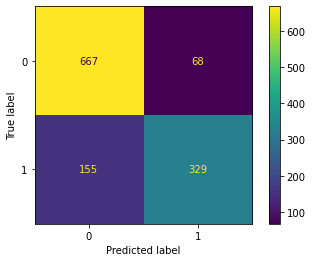

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=lr.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=lr.classes_)
disp.plot();

#### Support Vector Machines

In [67]:
svc = SVC()
svc.fit(X_train_tfid,y_train)

y_pred=svc.predict(X_test_tfid)
print("Accuracy : ",accuracy_score(y_test,y_pred)*100)
print("training accuracy: ", svc.score(X_train_tfid,y_train)*100)
print("testing accuracy: ", svc.score(X_test_tfid,y_test)*100)

Accuracy :  81.870385561936
training accuracy:  96.90334688770722
testing accuracy:  81.870385561936


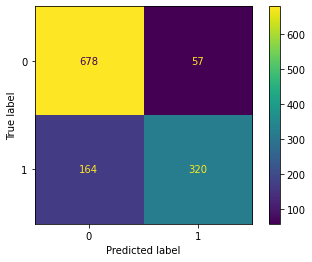

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=svc.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=svc.classes_)
disp.plot();

#### TfidfVectorizer with naive bayes

In [69]:
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [70]:
baseline_score = model_0.score(X_test, y_test)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 80.56%


In [71]:
baseline_preds = model_0.predict(X_test)

In [72]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [73]:
baseline_results = calculate_results(y_true=y_test,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 80.55783429040197,
 'precision': 0.8047917801669912,
 'recall': 0.8055783429040196,
 'f1': 0.8025871260127272}

### Deep learning models
#### LSTM model

In [74]:
# Custom Vectorization with Custom Variable
max_vocab_length = 20000 # max number of words to have in our vocabulary
max_length = 26 # max length our sequences will be 
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [75]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)
text_vectorizer.adapt(X_test)

In [76]:
words_in_vocab = text_vectorizer.get_vocabulary()

In [77]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

In [78]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)

x=layers.LSTM(64,return_sequences=True)(x)
x=layers.LSTM(64)(x)

x=layers.Dropout(0.4)(x)
x=layers.Dense(64,activation="relu")(x)
x=layers.Dropout(0.4)(x)

outputs=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs,outputs,name="Model_2_LSTM")

In [79]:
model_2.summary()
# While Sttacking RNN Models we need to return sequences mandatorily

Model: "Model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 26)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 26, 128)           2560000   
                                                                 
 lstm (LSTM)                 (None, 26, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                      

In [80]:
# Comiling and Fitting the Model
model_2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [81]:
history_2_model=model_2.fit(x=X_train,y=y_train, epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
200/200 [==============================] - 9s 34ms/step - loss: 0.5740 - accuracy: 0.6969 - val_loss: 0.4876 - val_accuracy: 0.7621
Epoch 2/100
200/200 [==============================] - 6s 31ms/step - loss: 0.4085 - accuracy: 0.8395 - val_loss: 0.4853 - val_accuracy: 0.7670
Epoch 3/100
200/200 [==============================] - 6s 29ms/step - loss: 0.3406 - accuracy: 0.8668 - val_loss: 0.5022 - val_accuracy: 0.7769
Epoch 4/100
200/200 [==============================] - 6s 29ms/step - loss: 0.3017 - accuracy: 0.8830 - val_loss: 0.5626 - val_accuracy: 0.7760
Epoch 5/100
200/200 [==============================] - 6s 30ms/step - loss: 0.2614 - accuracy: 0.9007 - val_loss: 0.6107 - val_accuracy: 0.7777
Epoch 6/100
200/200 [==============================] - 6s 31ms/step - loss: 0.2230 - accuracy: 0.9140 - val_loss: 0.7696 - val_accuracy: 0.7719
Epoch 7/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2013 - accuracy: 0.9151 - val_loss: 0.7236 - val_accuracy:

200/200 [==============================] - 6s 31ms/step - loss: 0.0439 - accuracy: 0.9792 - val_loss: 2.0224 - val_accuracy: 0.7580
Epoch 58/100
200/200 [==============================] - 6s 31ms/step - loss: 0.0431 - accuracy: 0.9790 - val_loss: 2.1292 - val_accuracy: 0.7465
Epoch 59/100
200/200 [==============================] - 6s 31ms/step - loss: 0.0381 - accuracy: 0.9811 - val_loss: 2.5147 - val_accuracy: 0.7465
Epoch 60/100
200/200 [==============================] - 6s 31ms/step - loss: 0.0379 - accuracy: 0.9800 - val_loss: 2.6948 - val_accuracy: 0.7547
Epoch 61/100
200/200 [==============================] - 6s 32ms/step - loss: 0.0381 - accuracy: 0.9801 - val_loss: 2.7927 - val_accuracy: 0.7523
Epoch 62/100
200/200 [==============================] - 6s 31ms/step - loss: 0.0493 - accuracy: 0.9781 - val_loss: 1.4552 - val_accuracy: 0.7506
Epoch 63/100
200/200 [==============================] - 7s 33ms/step - loss: 0.0461 - accuracy: 0.9776 - val_loss: 2.4337 - val_accuracy: 0.746

In [85]:
model_2_predict_probs=model_2.predict(X_test)
model_2_predict_probs[:20]

array([[9.9999899e-01],
       [2.6118569e-05],
       [2.6493618e-07],
       [9.9999690e-01],
       [2.4817678e-07],
       [9.9999952e-01],
       [1.6756279e-07],
       [9.7588074e-01],
       [2.4794517e-07],
       [1.9471649e-07],
       [4.4859533e-07],
       [1.7671316e-06],
       [9.9981987e-01],
       [1.6234502e-07],
       [2.4128903e-07],
       [1.7515580e-06],
       [9.9999875e-01],
       [6.5946579e-03],
       [9.9999845e-01],
       [2.1075549e-07]], dtype=float32)

In [86]:
# Converting these Probabilites to Labels of 0 and 1
model_2_predictions=tf.squeeze(tf.round(model_2_predict_probs))
model_2_predictions

<tf.Tensor: shape=(1219,), dtype=float32, numpy=array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)>

In [87]:
model_2_res=calculate_results(y_true=y_test,y_pred=model_2_predictions)
model_2_res

{'accuracy': 72.43642329778507,
 'precision': 0.7328843151599059,
 'recall': 0.7243642329778507,
 'f1': 0.7266377181932903}